### Task 2 - Temporal Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

### <font color = "green">imports and preparation</font>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [4]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [5]:
#test function for unix time stamps to datetime
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [6]:
temp_nw.head(10)

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44
5,1,5,2002-08-01 23:04:48,2007-07-10 19:45:45
6,1,2,2002-08-01 23:04:48,2007-07-10 19:45:45
7,1,3,2006-06-06 12:47:15,2007-07-10 19:45:45
8,1,4,2002-08-01 23:04:48,2007-07-10 19:45:45
9,1,7,2002-08-01 23:04:48,2007-07-10 19:45:45


In [7]:
temp_nw.shape

(4729035, 4)

In [8]:
fh = open("data/tgraph_real_wikiedithyperlinks.txt", 'rb')
G_temp = nx.read_edgelist(fh,create_using=nx.DiGraph(), data=(('start',int), ('end', int)))
fh.close()

In [9]:
#nx.write_edgelist(G_temp, "G_temp.edgelist")

### Temporal Network Analysis
For the second task, the time information of each edge is taken into consideration. The most used temporal network analysis method is snapshot-based analysis. For each measure we need to find time-scales that gives us interesting result. It is important that the time intervals are consisently chosen during the same measure, but the time intervals can be different for each measure. This is because patterns in temporal networks can occur at different time scales. 
First, we explore the temporal networks, by plotting a few histograms. The first histogram gives us a insight how many links are added in each year.

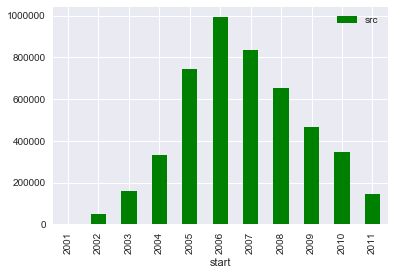

In [10]:
#plot that shows how many links are added in each year
temp_nw['src'].groupby(temp_nw["start"].dt.year).count().plot(kind="bar", legend=True, color = 'green')
plt.show()

The histogram looks like a bell curve. This means that most of the links are added in the years 2005-2008. Let's look if the removal of the links also have a bell shaped curve. 

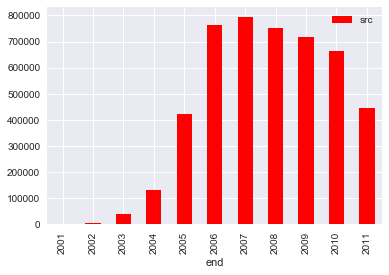

In [11]:
#plot that shows how many links are removed in each year
temp_nw['src'].groupby(temp_nw["end"].dt.year).count().plot(kind="bar", legend=True, color='red')
plt.show()

The histogram doesn't look like a bell curve. We actually see that the years 2006-2010 are the years in which most of the edges are removed. If we combine this with the information found above, we can conclude that the years 2006-2008 where the years in which the most links are added ánd removed from the wiki page. One can also be interested in the time duration of each link, i.e. how many years a link stays in the graph until it is removed. 

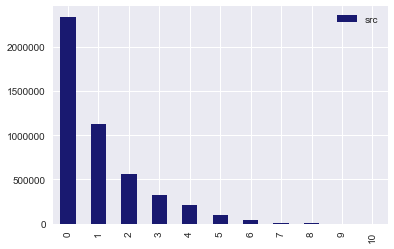

In [12]:
#plot which shows how many years each link remains in the graph bevore it is removed.
temp_nw['src'].groupby((temp_nw['end'].dt.year - temp_nw['start'].dt.year)).count().plot(kind="bar", legend=True, color='midnightblue')
plt.show()

From the histogram above we can see that a lot of links have a very short time duration in the graph. Most of the links are added and removed from the wiki page within a year. Furthermore we see that the other links doesn't stay long either in the graph. We can say that most of the links remain zero to two years in the network.

### Cluster Coefficient: Temporal Network
As we have seen in the static network analysis, cluster coefficient is very strong related to the largest connected component and the average degree of the neighbor nodes (which is treated in the Assortativity analysis). Measuring the cluster coefficient in a temporal network, where each edge has a start and end time, can give very interesting results. The goal of this measure in temporal network analysis is that we try to find time scales where the clustering coefficient of the graph (i.e. the average of the cluster coefficients of all the nodes) is very low or high. We can relate this cluster coefficient to for example how many nodes or edges there currently are on that particular timestamp, or what the degree distribution is of each node. The most difficult part is to choose propiate time intervals. Thanks to the explorative analysis above, the histogram give us some insight in what time intervals could be interesting to choose. Note that once one time interval is chosen, we will consistently use this "length" during the analysis of the measure. The histograms above only information about the addition and removal of links in the network. However, we saw from the static analysis that the (average) clustering coefficient depends on the average neighbor degree. Larger the neighbor degree is in the network, the larger the clustering coefficient. This is because the numerator of the fraction in the clustering coefficient formula basicly is the average neighbor degree of the node we want to calculate the clustering coefficient of. Also the average degree of all the nodes in the network are interesting to know how they change over time. We will plot these two statistics of the network in the next cells. 

In [107]:
def total_average__neighbor_deg_per_year(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
 
    df_year = df_temporal.loc[((df_temporal['start'] >= t_1) & (df_temporal['start'] < t_2)) | ((df_temporal['end'] >= t_1) & (df_temporal['end'] < t_2))]
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    average_deg = nx.average_neighbor_degree(G_year, source='out', target='in')
    average_deg_graph = sum(average_deg.values()) / len(average_deg)
    time_interval = str(t_1_year)+"-"+str(t_2_year)

    return average_deg_graph

In [125]:
avg_neighbor_deg = { 'avg deg': [total_average__neighbor_deg_per_year(temp_nw, i, i+2) for i in range(2000,2010)], 'time_interval' : [str(i)+"-"+str(i+2) for i in range(2000,2010)]}
df_avg_neighbor_deg = pd.DataFrame(data=avg_neighbor_deg)

In [126]:
df_avg_neighbor_deg.head(10)

,avg deg,time_interval
0,0.083679,2000-2002
1,23.958361,2001-2003
2,24.166988,2002-2004
3,52.377140,2003-2005
4,205.129739,2004-2006
5,331.917967,2005-2007
6,316.005943,2006-2008
7,178.432683,2007-2009
8,207.987382,2008-2010
9,196.971888,2009-2011


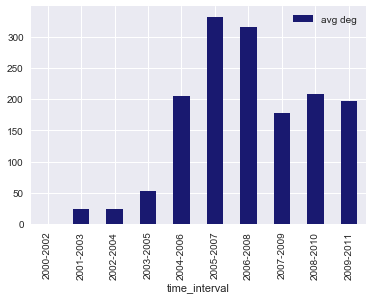

In [127]:
df_avg_deg.plot.bar(x = 'time_interval', color='midnightblue');
plt.show()

The histogram shows us that the average neighbor degree in the temporal network is very high in the period 2005-2007 and 2006-2008. These are also the two periods where the network contains the most edges, therefore the average degree of each node increases. What is interesting, is that the degree in last two years are also quite high. This is interesting, because from the histograms above we say that these periods (2008-2010 and 2009-2011) are the periods where there are more links removed from the network then links that are added to the network. Therefore we would expect that the average degree of the neighbors would decrease, but the bar plot shows something differently.

In [139]:
'''
def total_average_deg_per_year(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
 
    df_year = df_temporal.loc[((df_temporal['start'] >= t_1) & (df_temporal['start'] < t_2)) | ((df_temporal['end'] >= t_1) & (df_temporal['end'] < t_2))]
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    deg = { 'avg deg': [G_year.degree(node) for node in list(G_year.nodes())], 'node' : [node for node in list(G_year.nodes())]}
    print(len(deg.values()))
    average_deg_graph = sum(deg.values()) / len(deg)
    time_interval = str(t_1_year)+"-"+str(t_2_year)

    return average_deg_graph
'''


In [141]:
#avg_deg = { 'avg deg': [total_average_deg_per_year(temp_nw, i, i+2) for i in range(2000,2010)], 'time_interval' : [str(i)+"-"+str(i+2) for i in range(2000,2010)]}
#df_deg = pd.DataFrame(data=avg_deg)

In [13]:
def clustering_directed(G):
    td_iter = nx.cluster._triangles_and_degree_iter(G)
    clusterc = {v: 0 if t == 0 else (t) / (d * (d - 1)) for
                        v, d, t, _ in td_iter}
    return clusterc

In [14]:
def average_clustering_directed(G):
    c = clustering_directed(G).values()
    return sum(c) / len(c)

In [87]:
temp_nw_2011 = temp_nw.loc[(temp_nw['start'].dt.year == 2011) | (temp_nw['end'].dt.year == 2013)]
temp_nw_2011.head()

,src,trg,start,end
26,1,3,2011-05-10 14:43:59,2011-05-10 18:04:31
1626,1097,10659,2011-04-08 08:03:52,2011-04-08 08:27:01
1750,10922,2990,2011-05-14 06:06:34,2011-06-21 07:31:09
2384,230,9,2011-04-11 10:02:52,2011-05-02 11:05:56
2404,684,5,2011-02-01 09:36:33,2011-02-01 09:37:57


In [16]:
'''
import time
import datetime
temp_nw_2011['start'] = (temp_nw_2011['start'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
temp_nw_2011['end'] = (temp_nw_2011['end'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
#temp_nw['end'] = pd.to_datetime(temp_nw['end']).astype(int)
'''

"\nimport time\nimport datetime\ntemp_nw_2011['start'] = (temp_nw_2011['start'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')\ntemp_nw_2011['end'] = (temp_nw_2011['end'] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')\n#temp_nw['end'] = pd.to_datetime(temp_nw['end']).astype(int)\n"

In [17]:
temp_nw_2011.shape

(146479, 4)

In [41]:
G_temp_2011 = nx.from_pandas_dataframe(temp_nw_2011, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())

In [19]:
#nx.write_edgelist(G_temp_2011, "G_temp_2011.edgelist")